In [1]:
from matplotlib import pyplot as plt
import numpy as np
import copy

In [2]:
def CV_now(tm, CVS, CVD):
    tc = np.fmod(tm, T)
    if tc < TS:
        e = (1.0 - np.exp(-tc / tauS)) / (1.0 - np.exp(-TS / tauS))
        CV = CVD * np.power((CVS / CVD), e)
    else:
        e = (1 - np.exp(-(tc - TS) / tauD)) / (1 - np.exp(-(T - TS) / tauD))
        CV = CVS * np.power((CVD / CVS), e)
    return CV


def set_valves(Pold, Cold, Ci, Si, Gi):
    # script to find self - consistent valve states and pressures:
    done = 0  # not done yet!
    S_l = copy.deepcopy(Si)
    while ~done:  # if not done, keep trying
        S_noted = copy.deepcopy(S_l)  # note valve states
        # set pressures based on valve states:
        P_l = P_new(Pold, Cold, Ci, S_l, Gi)
        # then set valve states based on pressures:
        P_matrix = P_l * np.ones((1, N))
        S_l = (P_matrix > np.transpose(P_matrix))
        # done if all valve states are unchanged:
        done = np.all(np.all(S_l == S_noted))
    return P_l, S_l


def P_new(Pold, Cold, Ci, Si, Gi):
    A = -dt * (np.multiply(Si, Gi) + np.transpose(np.multiply(Si, Gi)))
    dd = np.diag(Ci.flatten()-(np.sum(A, axis=0))) + A
    A = dd
    tmp = np.linalg.solve(A, np.multiply(Cold, Pold))
    P_l = tmp
    CH = np.zeros((N, 1))
    if CHECK:
        for i_l in np.arange(N):
            CH[i_l] = -(Ci[i_l] * P_l[i_l, 0] - Cold[i_l] * Pold[i_l, 0]) / dt
            for j_l in np.arange(N):
                CH[i_l] = CH[i_l] + Si[j_l, i_l] * Gi[j_l, i_l] * (P_l[j_l, 0] - P_l[i_l, 0])
                CH[i_l] = CH[i_l] - Si[i_l, j_l] * Gi[i_l, j_l] * (P_l[i_l, 0] - P_l[j_l, 0])
        #print(CH) 
        # Write out the  values of CH, which should be zero to within roundoff. 
    return P_l


def circ_out():
    #script to plot results of computer simulation of the entire circulation.
    #left ventricular compliance, pressures, and flows:
    fig, a = plt.subplots(3)
    a[0].plot(t_plot.flatten(), C_plot[iLV, :])
    a[1].plot(t_plot.flatten(), P_plot[ipv, :])
    a[1].plot(t_plot.flatten(), P_plot[iLV, :])
    a[1].plot(t_plot.flatten(), P_plot[isa, :])
    a[2].plot(t_plot.flatten(), Q_plot[jMi, :])
    a[2].plot(t_plot.flatten(), Q_plot[jAo, :])

    # right ventricular compliance, pressures, and flows:
    fig, b = plt.subplots(3)
    b[0].plot(t_plot.flatten(), C_plot[iRV, :])
    b[1].plot(t_plot.flatten(), P_plot[isv, :])
    b[1].plot(t_plot.flatten(), P_plot[iRV, :])
    b[1].plot(t_plot.flatten(), P_plot[ipa, :])
    b[2].plot(t_plot.flatten(), Q_plot[jTr, :])
    b[2].plot(t_plot.flatten(), Q_plot[jPu, :])

    # systemic and pulmonary flows:
    fig, c = plt.subplots()
    c.plot(t_plot.flatten(), Q_plot[js, :])
    c.plot(t_plot.flatten(), Q_plot[jp, :])

    fig, d = plt.subplots(2) # pressure-volume loops for both ventricles
    d[0].plot(V_plot[iLV, :], P_plot[iLV, :])
    d[1].plot(V_plot[iRV, :], P_plot[iRV, :])
    
    plt.show()


In [3]:
T = 0.0125  # Duration of heartbeat (minutes)
TS = 0.0050  # Duration of systole   (minutes)
tauS = 0.0025  # CLV time constant during systole (minutes)
tauD = 0.0075  # CLV time constant during diastole (minutes)
Rs = 17.5  # Systemic resistance  (mmHg/(liter/minute))
Rp = 1.79  # Pulmonary resistance (mmHg/(liter/minute))
# Unrealistic valve resistances,
# Chosen small enough to be negligible.
RMi = 0.01  # mitral valve resistance (mmHg/(liter/minute))
RAo = 0.01  # aortic valve resistance (mmHg/(liter/minute))
RTr = 0.01  # tricuspid valve resistance (mmHg/(liter/minute))
RPu = 0.01  # pulmonic valve  resistance (mmHg/(liter/minute))
# The following values of Csa and Cpa are approximate.
# They will need adjustment to make the systemic
# blood pressure be roughly 120/80 mmHg
# and to make the pulmonary
# blood pressure be roughly 25/8 mmHg.
Csa = 0.00175  # Systemic  arterial compliance (liters/mmHg)
Cpa = 0.00412  # Pulmonary arterial compliance (liters/mmHg)
Csv = 1.75  # Systemic  venous compliance (liters/mmHg)
Cpv = 0.08  # Pulmonary venous compliance (liters/mmHg)
CLVS = 0.00003  # Min (systolic)  value of CLV (liters/mmHg)
CLVD = 0.0146  # Max (diastolic) value of CLV (liters/mmHg)
CRVS = 0.0002  # Min (systolic)  value of CRV (liters/mmHg)
CRVD = 0.0365  # Max (diastolic) value of CRV (liters/mmHg)
Vsad = 0.825  # Systemic arterial volume at P = 0 (liters)
Vpad = 0.0382  # Pulmonary arterial volume at P = 0 (liters)
Vsvd = 0  # Systemic venous volume at P = 0 (liters)
Vpvd = 0  # Pulmonary venous volume at P = 0 (liters)
VLVd = 0.027  # Left ventricular volume at P = 0 (liters)
VRVd = 0.027  # Right ventricular volume at P = 0 (liters)
dt = 0.01 * T  # Time step duration (minutes)
# This choice implies 100 timesteps per cardiac cycle.
klokmax = 15 * int(T / dt)  # Total number of timesteps
# This choice implies simulation of 15 cardiac cycles.
# Assign an index to each compliance vessel
# of the model circulation:
iLV = 0
isa = 1
isv = 2
iRV = 3
ipa = 4
ipv = 5
N = 6
# Enter parameters and initial values
# into correct slots in arrays.
# Note that the code that follows is independent
# of the specific numbering scheme chosen above.
# Compliance vector:
C = np.zeros((N, 1))
# This makes C a column vector of length N.
C[iLV] = CV_now(0.0, CLVS, CLVD)  # initial value
C[isa] = Csa
C[isv] = Csv
C[iRV] = CV_now(0.0, CRVS, CRVD)  # initial value
C[ipa] = Cpa
C[ipv] = Cpv
#print(C)  # This writes the result on the screen.
# Pressure vector (initial values) at end of diastole:
P = np.zeros((N, 1))
# This makes P a column vector of length N.
P[iLV] = 5
P[isa] = 80
P[isv] = 2
P[iRV] = 2
P[ipa] = 8
P[ipv] = 5
#print(P)  # This writes the result on the screen.
# Vector of dead volumes (volume at zero pressure)
# Note: Vd is only needed for output purposes.
# It drops out of the equations we solve for P,
# but we need it if we want to output (e.g.,  plot)
# the volume of any compliance vessel.
Vd = np.zeros((N, 1))
# This makes Vd a column vector of length N.
Vd[iLV] = VLVd
Vd[isa] = Vsad
Vd[isv] = Vsvd
Vd[iRV] = VRVd
Vd[ipa] = Vpad
Vd[ipv] = Vpvd
#print(Vd)
# This writes the results on the screen.
# Conductance matrix:
G = np.zeros((N, N))
# This makes G an NxN matrix filled with zeros.
# Any element of G that is not explicitly
# made nonzero remains zero,
# thus modeling an infinite resistance connection,
# that is,  no connection at all.
G[iLV, isa] = 1 / RAo  # But G(isa, iLV) = 0 (no leak)
G[isa, isv] = 1 / Rs  # no valve
G[isv, isa] = 1 / Rs  # no valve
G[isv, iRV] = 1 / RTr  # But G(iRV, isv) = 0  (no leak)
G[iRV, ipa] = 1 / RPu  # But G(ipa, iRV) = 0  (no leak)
G[ipa, ipv] = 1 / Rp  # no valve
G[ipv, ipa] = 1 / Rp  # no valve
G[ipv, iLV] = 1 / RMi  # But G(iLV, ipv) = 0  (no leak)
#print(G)  # This writes the result on the screen.
# Matrix of initial valve states:
S = np.zeros((N, N))
# This makes S an NxN matrix filled with zeros
# (and writes it on the screen).
# Start with all valves closed.
# Valves will adjust to pressures
# during first time step.
# Initialize arrays to store data for plotting:
t_plot = np.zeros((1, klokmax))
C_plot = np.zeros((N, klokmax))
P_plot = np.zeros((N, klokmax))
V_plot = np.zeros((N, klokmax))
Q_plot = np.zeros((N, klokmax))
# Other variables that we might want to plot
# can be found from these.
# For self-checking in P_new,  set CHECK = 1.
# To skip self-checking set CHECK = 0.
# (should be much faster with CHECK = 0)
CHECK = 1
# Initialize flow computation (for output purposes only)
# assign an index to each flow of interest:
jAo = 0
js = 1
jTr = 2
jPu = 3
jp = 4
jMi = 5
Nflows=6;   
# note index of upstream and downstream chamber
# for each flow:
iU = np.zeros((Nflows, 1))
iD = np.zeros((Nflows, 1))
iU[jAo] = iLV
iD[jAo] = isa
iU[js] = isa
iD[js] = isv
iU[jTr] = isv
iD[jTr] = iRV
iU[jPu] = iRV
iD[jPu] = ipa
iU[jp] = ipa
iD[jp] = ipv
iU[jMi] = ipv
iD[jMi] = iLV
# extract the conductances from the matrix G:
Gf = np.zeros((Nflows, 1))
Gr = np.zeros((Nflows, 1))
for j in np.arange(Nflows):
    Gf[j] = G[int(iU[j]), int(iD[j])]  # forward conductance
    Gr[j] = G[int(iD[j]), int(iU[j])]  # reverse conductance
# create arrays to store current pressure differences
# and history over time of the net flows
Pdiff = np.zeros((Nflows, 1))
Q_plot = np.zeros((Nflows, klokmax))

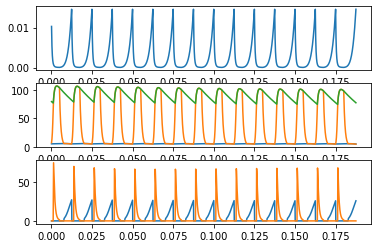

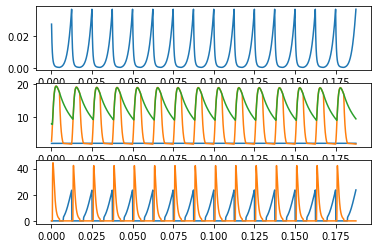

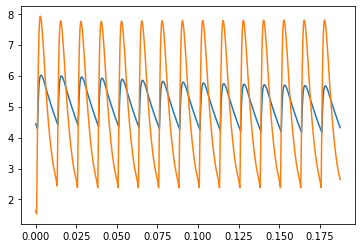

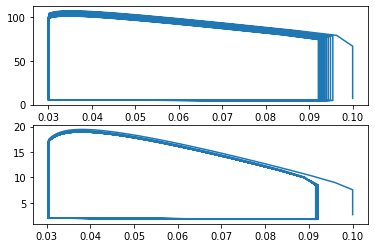

In [4]:
for klok in np.arange(klokmax):
    t = (klok+1) * dt
    P_old = copy.deepcopy(P)
    C_old = copy.deepcopy(C)
    # find current values of left and right ventricular compliance and store each
    # of them in the appropriate slot in the array C:
    C[iLV, 0] = CV_now(t, CLVS, CLVD)
    C[iRV, 0] = CV_now(t, CRVS, CRVD)
    # find self - consistent valve states and pressures:
    P, S = set_valves(P_old, C_old, C, S, G)
    # store variables in arrays for future plotting
    t_plot[0, klok] = t
    C_plot[:, klok] = C[:, 0]
    P_plot[:, klok] = P[:, 0]
    V_plot[:, klok] = Vd[:, 0] + np.multiply(C, P)[:, 0]
    Pdiff = P[iU.astype(int)].flatten() - P[iD.astype(int)].flatten()  
    # pressure differences for flows of interest:
    Q_plot[:, klok] = np.multiply(np.multiply(Gf.flatten(), Pdiff > 0) + np.multiply(Gr.flatten(), Pdiff < 0), Pdiff)
    # (the net flow is computed in each case)
circ_out()